**Regression attempt 2 (added features). Also has first attempts of binary classification**


Re-Ran 9/26 to get updated results for the webpage

In [1]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler as SS
from sklearn.linear_model import LinearRegression as LinearRegression, Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBRegressor


Prevoius efforts to build a model to predict ship sink percentages have proved unsucessful. New features have been added to the data set which include time of year (in the form of the depart month and year), average number of U-Boats at sea (from http://www.ibiblio.org/hyperwar/USN/rep/ASW-51/ASW-8.html), prevoius month's sink percentages, time at sea (days), and escort ratio and approximate sighting range (calculated from https://www.ibiblio.org/hyperwar/USN/rep/ASW-51/ASW-10.html). A different notebook will look at feature importance and selection. Additionally, a new approach to predicting convoy saftey will be taken in the form of classifers predicting high vs low risk conovys.

In [2]:
#Complied data of convoys
#Routes examined are HX, SC, OB, ON, ONS
df = pd.read_csv('/Users/matthewplambeck/Desktop/Convoy Predictor/data/processed/Complete_Convoy_Data.csv')
df = df.drop(columns=['Unnamed: 0'])
df.shape
df.head(3)

,Convoy Number,Number of Ships,Number of Escort Ships,Number of Stragglers,Number of Ships Sunk,Number of Escorts Sunk,Number of Stragglers Sunk,Total Tons of Convoy,Total Tons of Ships Sunk,Depart_Date,...,Overall Sink Percentage,Escort Sink Percentage,Straggler Sink Percentage,Avg Number of U-Boats in Atlantic,Escort Ratio,Time At Sea (Days),Month,Year,Previous Month Avg Sink %,Approx. Sighting Range
0,OB.1,5.0,2.0,0.0,0.0,0.0,0.0,22877.0,0.0,1939-09-07 00:00:00,...,0.0,0.0,0.0,6.0,0.400000,3.0,9.0,1939.0,0.0,12.190200
1,OB.2,5.0,2.0,0.0,0.0,0.0,0.0,22967.0,0.0,1939-09-09 00:00:00,...,0.0,0.0,0.0,6.0,0.400000,5.0,9.0,1939.0,0.0,12.190200
2,OB.3,7.0,4.0,0.0,0.0,0.0,0.0,21293.0,0.0,1939-09-11 00:00:00,...,0.0,0.0,0.0,6.0,0.571429,5.0,9.0,1939.0,0.0,14.434062


In [3]:
# The number of convoys which were at sea for less than 5 days. Would have dispersed after said time in convoy
len(df[df['Time At Sea (Days)'] < 10])

289

In [4]:
df.describe()

,Number of Ships,Number of Escort Ships,Number of Stragglers,Number of Ships Sunk,Number of Escorts Sunk,Number of Stragglers Sunk,Total Tons of Convoy,Total Tons of Ships Sunk,Overall Sink Percentage,Escort Sink Percentage,Straggler Sink Percentage,Avg Number of U-Boats in Atlantic,Escort Ratio,Time At Sea (Days),Month,Year,Previous Month Avg Sink %,Approx. Sighting Range
count,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1.174000e+03,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.00000,1174.000000,1174.000000,1174.000000,1174.000000
mean,56.930153,13.799830,0.481261,0.648211,0.030664,0.129472,2.651633e+05,3541.982112,1.246093,0.193813,7.608197,38.711244,0.235122,13.08092,6.573254,1941.795571,1.252933,23.420781
std,26.371021,7.924621,1.421755,1.916348,0.216332,0.476489,1.548845e+05,10508.457265,3.530696,1.324988,25.575738,32.714257,0.092281,5.49256,3.566109,1.676511,1.315712,1.481019
min,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.717500e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,1.000000,1939.000000,0.000000,10.878000
25%,39.000000,7.250000,0.000000,0.000000,0.000000,0.000000,1.550892e+05,0.000000,0.000000,0.000000,0.000000,12.000000,0.173175,10.00000,3.000000,1940.000000,0.073099,23.671536
50%,54.000000,14.000000,0.000000,0.000000,0.000000,0.000000,2.270795e+05,0.000000,0.000000,0.000000,0.000000,30.000000,0.238636,15.00000,7.000000,1942.000000,0.812526,23.932372
75%,73.000000,19.000000,0.000000,0.000000,0.000000,0.000000,3.353822e+05,0.000000,0.000000,0.000000,0.000000,54.000000,0.296166,17.00000,10.000000,1943.000000,1.974096,23.990864
max,191.000000,47.000000,22.000000,20.000000,4.000000,5.000000,1.062596e+06,93502.000000,46.511628,16.666667,100.000000,116.000000,0.571429,27.00000,12.000000,1945.000000,4.403733,24.000000


In [5]:
#Removing all the cases where a convoy dispersed. Ships were often sunk post dispersal as they lacked the protection of the convoy.
#This could skew sink percentages as ships sunk sailing independently (post-dispersion) will be counted as sunk in a convoy.
#It is worth noting however, that some of the convoys remaining did disperse, just much closer to land and the likelihood of a ship from a convoy \
# being sunk independently is much lower. 

df2 = df[df['Time At Sea (Days)'] > 10]
#df2.head(-1)
#296 Convoys are removed, mostly from the OB series as they dispersed 750 miles from shore 



#This Cell is up for debate over then inclusion of dispersal convoys. 

In [6]:
df2.describe()

,Number of Ships,Number of Escort Ships,Number of Stragglers,Number of Ships Sunk,Number of Escorts Sunk,Number of Stragglers Sunk,Total Tons of Convoy,Total Tons of Ships Sunk,Overall Sink Percentage,Escort Sink Percentage,Straggler Sink Percentage,Avg Number of U-Boats in Atlantic,Escort Ratio,Time At Sea (Days),Month,Year,Previous Month Avg Sink %,Approx. Sighting Range
count,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,8.780000e+02,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000
mean,65.453303,16.705011,0.592255,0.664009,0.036446,0.144647,3.048392e+05,3624.879271,1.136934,0.208872,8.085069,47.933941,0.259985,15.969248,6.507973,1942.346241,1.142846,23.852269
std,23.760722,6.700346,1.608142,2.082638,0.240755,0.512812,1.552837e+05,11342.177878,3.610733,1.326105,26.133486,32.675527,0.078474,2.486490,3.523086,1.543273,1.256960,0.553873
min,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.786800e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,1.000000,1939.000000,0.000000,10.878000
25%,49.000000,12.000000,0.000000,0.000000,0.000000,0.000000,1.900625e+05,0.000000,0.000000,0.000000,0.000000,24.000000,0.210526,14.000000,3.000000,1941.000000,0.073099,23.885472
50%,62.000000,17.000000,0.000000,0.000000,0.000000,0.000000,2.714735e+05,0.000000,0.000000,0.000000,0.000000,43.000000,0.258065,16.000000,6.000000,1942.000000,0.578835,23.970888
75%,79.000000,21.000000,1.000000,0.000000,0.000000,0.000000,3.908448e+05,0.000000,0.000000,0.000000,0.000000,66.000000,0.307692,17.000000,10.000000,1944.000000,1.921299,23.995145
max,191.000000,47.000000,22.000000,20.000000,4.000000,5.000000,1.062596e+06,93502.000000,46.511628,16.666667,100.000000,116.000000,0.558824,27.000000,12.000000,1945.000000,4.403733,24.000000


In [7]:
#Dropping the features that are not needed or give away information
df2 = df2.drop(columns=['Convoy Number', 'Number of Ships Sunk', 'Depart_Date', 'Arrival/Dispersal Date', 'Number of Escorts Sunk', \
                         'Number of Stragglers Sunk', 'Total Tons of Ships Sunk', 'Escort Sink Percentage', 'Straggler Sink Percentage'])
df2.reset_index(drop=True)

,Number of Ships,Number of Escort Ships,Number of Stragglers,Total Tons of Convoy,Overall Sink Percentage,Avg Number of U-Boats in Atlantic,Escort Ratio,Time At Sea (Days),Month,Year,Previous Month Avg Sink %,Approx. Sighting Range
0,22.0,4.0,0.0,99182.0,0.0,6.0,0.181818,14.0,9.0,1939.0,0.000000,22.030458
1,19.0,4.0,0.0,93630.0,0.0,6.0,0.210526,17.0,9.0,1939.0,0.000000,21.298297
2,4.0,0.0,0.0,17868.0,0.0,6.0,0.000000,15.0,9.0,1939.0,0.000000,10.878000
3,27.0,3.0,0.0,131859.0,0.0,6.0,0.111111,14.0,9.0,1939.0,0.000000,22.837005
4,13.0,3.0,0.0,51562.0,0.0,3.0,0.230769,14.0,10.0,1939.0,0.000000,18.916268
...,...,...,...,...,...,...,...,...,...,...,...,...
873,85.0,15.0,0.0,511572.0,0.0,0.0,0.176471,15.0,5.0,1945.0,0.098328,23.997420
874,30.0,9.0,0.0,103961.0,0.0,0.0,0.300000,14.0,5.0,1945.0,0.098328,23.152177
875,82.0,23.0,0.0,406154.0,0.0,0.0,0.280488,14.0,5.0,1945.0,0.098328,23.996461
876,43.0,12.0,0.0,210127.0,0.0,0.0,0.279070,13.0,5.0,1945.0,0.098328,23.784495


Fitting Models:

In [8]:
#Train Test Split
X = np.array(df2.drop(columns=['Overall Sink Percentage']))
y = df2['Overall Sink Percentage'].values
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.8, random_state=1945)
(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)

((702, 11), (176, 11), (702,), (176,))

In [9]:
#K-Fold Cross Validation Function
def K_Fold(model, X, y, K, scaler=None, random_state=1945):
    kf = KFold(n_splits=K, random_state=random_state, shuffle=True)
    train_scores = []
    test_scores = []
    for idxTrain, idxTest in kf.split(X):
        Xtrain = X[idxTrain]
        Xtest = X[idxTest]
        ytrain = y[idxTrain]
        ytest = y[idxTest]
        if scaler is not None:
            Xtrain = scaler.fit_transform(Xtrain)
            Xtest = scaler.transform(Xtest)
        model.fit(Xtrain, ytrain)
        train_scores.append(model.score(Xtrain, ytrain))
        test_scores.append(model.score(Xtest, ytest))
    return train_scores, test_scores

In [10]:
#Standard Scaler
SS = SS()

In [14]:
#Linear Regression
Xtrain_scaled = SS.fit_transform(Xtrain)
LR_model = LinearRegression()
LR_model.fit(Xtrain_scaled, ytrain)
y_predict = LR_model.predict(SS.transform(Xtest))
print('Linear Regression Train Score (R\u00b2):', LR_model.score(Xtrain_scaled, ytrain))
print('Linear Regression Test Score (R\u00b2):', LR_model.score(SS.transform(Xtest), ytest))
print('Linear Regression Coefficients: \n', LR_model.coef_)
print('Linear Regression Intercepts:', LR_model.intercept_)
train_scores, test_scores = K_Fold(LR_model, X, y, 10, SS)
print('K-Fold Linear Regression Train Score (Mean R\u00b2):  ', np.mean(train_scores))
print('K-Fold Linear Regression Testing Score (Mean R\u00b2):', np.mean(test_scores))

Linear Regression Train Score (R²): 0.11969038809614996
Linear Regression Test Score (R²): 0.09471485347835706
Linear Regression Coefficients: 
 [ 1.119557    0.25620009  0.62298168 -1.50036434  0.13971672 -0.5357547
  0.00872498  0.13380349  0.03689159  0.74722931  0.04653799]
Linear Regression Intercepts: 1.114447202245706
K-Fold Linear Regression Train Score (Mean R²):   0.11892276888042556
K-Fold Linear Regression Testing Score (Mean R²): 0.04799680826853505


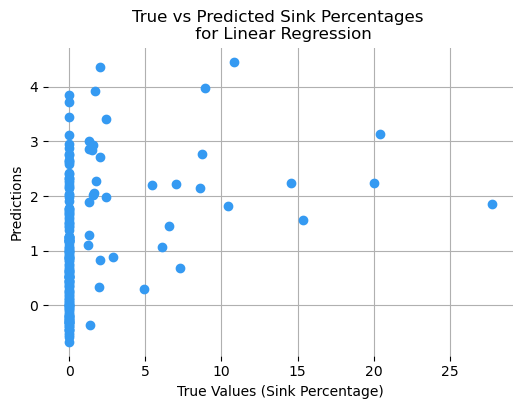

In [15]:
#Examining True vs Predicted Sink Rates for the Linear Regression model
plt.figure(figsize=(6,4))
plt.scatter(ytest, y_predict, color='#359af2', zorder=3)
plt.xlabel('True Values (Sink Percentage)')
plt.ylabel('Predictions')
plt.title('True vs Predicted Sink Percentages \n for Linear Regression')
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.grid()
plt.savefig('/Users/matthewplambeck/Desktop/Convoy Predictor/Plots/LinReg_TP.png')

In [16]:
#Cross-validation for optimal n_estimators for use in Random Forest Regressor
param_grid = {'n_estimators': [241, 242, 243]}
RF_Model = RandomForestRegressor(random_state=1945)
grid_search = GridSearchCV(estimator=RF_Model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid_search.fit(Xtrain, ytrain)
best_param = grid_search.best_params_
best_score = grid_search.best_score_
print(best_param)
print('Best Score:', best_score)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


{'n_estimators': 242}
Best Score: -13.726806629882997


In [17]:
#Random Forest Regressor
Ran_Forest_Model = RandomForestRegressor(n_estimators=242, random_state=1945) #n_estimators has been optimized using cross-validation
Ran_Forest_Model.fit(Xtrain, ytrain)
ypredict = Ran_Forest_Model.predict(Xtest)
RFR_mse = mean_squared_error(ytest, ypredict)
print('Random Forest Regressor Train Score (R\u00b2):', Ran_Forest_Model.score(Xtrain, ytrain))
print('Random Forest Regressor Test Score (R\u00b2):', Ran_Forest_Model.score(Xtest, ytest))
print('Random Forest Regressor Mean Squared Error', RFR_mse)
train_scores, test_scores = K_Fold(Ran_Forest_Model, X, y, 10, )
print('K-Fold Random Forest Regressor Train Score (Mean R\u00b2):', np.mean(train_scores))
print('K-Fold Random Forest Regressor Test Score (Mean R\u00b2):',np.mean(test_scores))

Random Forest Regressor Train Score (R²): 0.8609195009364222
Random Forest Regressor Test Score (R²): 0.028218849398163104
Random Forest Regressor Mean Squared Error 13.929204426875025
K-Fold Random Forest Regressor Train Score (Mean R²): 0.8614703942611415
K-Fold Random Forest Regressor Test Score (Mean R²): -0.1784705383877128


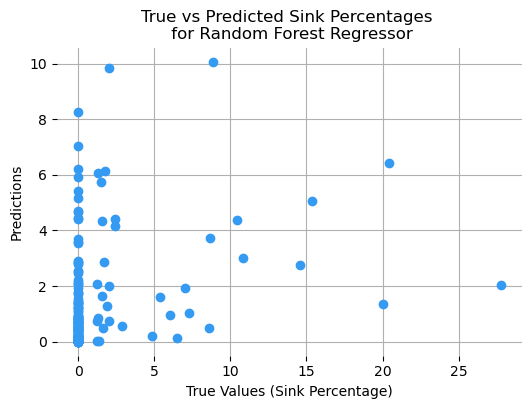

In [18]:
#Examining True vs Predicted Sink Rates for the Random Forest Regressor model
plt.figure(figsize=(6,4))
plt.scatter(ytest, ypredict, color='#359af2', zorder=3)
plt.xlabel('True Values (Sink Percentage)')
plt.ylabel('Predictions')
plt.title('True vs Predicted Sink Percentages \n for Random Forest Regressor')
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.grid()
plt.savefig('/Users/matthewplambeck/Desktop/Convoy Predictor/Plots/RanFor_TP.png')

In [19]:
#Gradient Boosting Regressor
GB_model = GradientBoostingRegressor(random_state=1945)
GB_model.fit(Xtrain, ytrain)
ypredict = GB_model.predict(Xtest)
GB_mse = mean_squared_error(ytest, ypredict)
print('Gradient Boosting Regressor Train Score (Mean Accuracy):', GB_model.score(Xtrain, ytrain))
print('Gradient Boosting Regressor Test Score (Mean Accuracy):', GB_model.score(Xtest, ytest))
print('Gradient Boosting Regressor Mean Squared Error', GB_mse)
train_scores, test_scores = K_Fold(GB_model, X, y, 10, )
print('K-Fold Gradient Boosting Train Score (Mean R\u00b2):', np.mean(train_scores))
print('K-Fold Gradient Boosting Test Score (Mean R\u00b2):',np.mean(test_scores))

Gradient Boosting Regressor Train Score (Mean Accuracy): 0.8108159645821675
Gradient Boosting Regressor Test Score (Mean Accuracy): 0.0706649811725899
Gradient Boosting Regressor Mean Squared Error 13.320794965290075
K-Fold Gradient Boosting Train Score (Mean R²): 0.7650187716574124
K-Fold Gradient Boosting Test Score (Mean R²): -0.2242567375852599


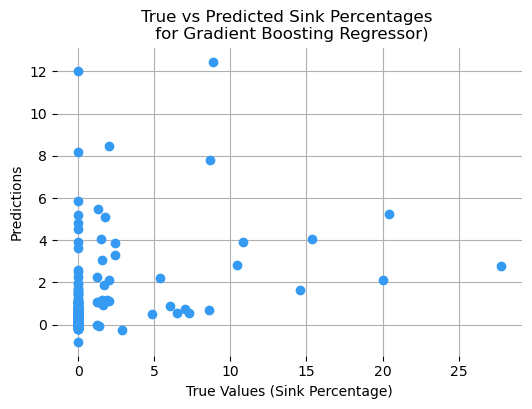

In [20]:
#Examining True vs Predicted Sink Rates for the Gradient Boosting Regressor model
plt.figure(figsize=(6,4))
plt.scatter(ytest, ypredict, color='#359af2', zorder=3)
plt.xlabel('True Values (Sink Percentage)')
plt.ylabel('Predictions')
plt.title('True vs Predicted Sink Percentages \n for Gradient Boosting Regressor)')
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.grid()
plt.savefig('/Users/matthewplambeck/Desktop/Convoy Predictor/Plots/GB_TP.png')

In [21]:
#Find Optimal Alpha Value For Ridge Regression
a_range = np.linspace(0,600,301) 
avg_tr_score = []
avg_te_score = []
for a in a_range:
    rid_reg = Ridge(alpha=a, max_iter=10000)
    train_scores, test_scores = K_Fold(rid_reg, X, y, 10, SS)
    avg_tr_score.append(np.mean(train_scores))
    avg_te_score.append(np.mean(test_scores))
alpha_max = a_range[np.argmax(avg_te_score)]
print('Optimal \u03B1 Value:', alpha_max)
#print(a_range)

Optimal α Value: 470.0


In [22]:
#Ridge Regression
rid_reg = Ridge(alpha=470, max_iter=10000) #Using optimal alpha value
train_scores, test_scores = K_Fold(rid_reg, X, y, 10, SS)
print('K-Fold Ridge Regression Train Score (R\u00b2):', np.mean(train_scores))
print('K-Fold Ridge Regression Test Score (R\u00b2):',np.mean(test_scores))

K-Fold Ridge Regression Train Score (R²): 0.09765564553384137
K-Fold Ridge Regression Test Score (R²): 0.06602236493119991


**Classification:**


Was not re-run. Classification tests done elsewhere...

In [82]:
#Find Optimal Number of Neighbors for KNN
neighbors = np.linspace(1,30,30) 
neighbors_int = neighbors.astype(int)
avg_tr_score = []
avg_te_score = []
for a in neighbors_int:
    knn = KNeighborsRegressor(n_neighbors=a)
    train_scores, test_scores = K_Fold(knn, X, y, 10, SS)
    avg_tr_score.append(np.mean(train_scores))
    avg_te_score.append(np.mean(test_scores))
n_neighbors = neighbors_int[np.argmax(avg_te_score)]
print('Optimal Number of Neighbors (Test Score):', n_neighbors)

Optimal Number of Neighbors (Test Score): 20


In [84]:
#K-Nearest Neighbors 
knn = KNeighborsRegressor(n_neighbors=20) #Number of neighbors optimized by best test score. weights='uniform' performs slightly better.
Xtrain_scaled = SS.fit_transform(Xtrain)
knn.fit(Xtrain_scaled, ytrain)
ypredict_knn = knn.predict(SS.transform(Xtest))
mse_knn = mean_squared_error(ytest, ypredict_knn)
r2_knn = r2_score(ytest, ypredict_knn)
print('KNN Train Score (Mean Accuracy):', knn.score(Xtrain_scaled, ytrain))
print('KNN Test Score (Mean Accuracy):', knn.score(SS.transform(Xtest), ytest))
print('KNN Mean Squared Error', mse_knn)
#cm = compare_classes()
train_scores, test_scores = K_Fold(knn, X, y, 10, SS)
print('K-Fold KNN Train Score (Mean Accuracy):', np.mean(train_scores))
print('K-Fold KNN Test Score (Mean Accuracy):',np.mean(test_scores))

KNN Train Score (Mean Accuracy): 0.16840135446750626
KNN Test Score (Mean Accuracy): 0.05183816219137438
KNN Mean Squared Error 13.590652648920498
K-Fold KNN Train Score (Mean Accuracy): 0.18279714911443246
K-Fold KNN Test Score (Mean Accuracy): 0.10012760861380307


Overall Sink Percentage will be changed to a binary target variable with 0 indicating no ships sunk and 1 indicating at least one ship sunk. Predicting a convoy's sink percentage accurately has proved unrealistic, a shift in focus to predicting convoys at risk of losing ships is necessary. There are too many variables that go into convoy attacks that can not be captured as features (evasive maneuvers, night vs day attack, weather, number of U-Boats attacking, etc). 


In [60]:
#Changing 'Overall Sink Percentage' to a binary value
df2['High Risk'] = (df2['Overall Sink Percentage'] > 0).astype(int)
X = np.array(df2.drop(columns=['Overall Sink Percentage', 'High Risk']))
y = df2['High Risk'].values
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size = 0.8, random_state=1945)
df2.head()
#(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)

,Number of Ships,Number of Escort Ships,Number of Stragglers,Total Tons of Convoy,Overall Sink Percentage,Avg Number of U-Boats in Atlantic,Escort Ratio,Time At Sea (Days),Month,Year,Previous Month Avg Sink %,Approx. Sighting Range,High Risk
5,22.0,4.0,0.0,99182.0,0.0,6.0,0.181818,14.0,9.0,1939.0,0.0,22.030458,0
9,19.0,4.0,0.0,93630.0,0.0,6.0,0.210526,17.0,9.0,1939.0,0.0,21.298297,0
13,4.0,0.0,0.0,17868.0,0.0,6.0,0.000000,15.0,9.0,1939.0,0.0,10.878000,0
14,27.0,3.0,0.0,131859.0,0.0,6.0,0.111111,14.0,9.0,1939.0,0.0,22.837005,0
18,13.0,3.0,0.0,51562.0,0.0,3.0,0.230769,14.0,10.0,1939.0,0.0,18.916268,0


In [30]:
#Random Forest Classifier
Ran_Forest_Classifier = RandomForestClassifier(random_state=1945)
Ran_Forest_Classifier.fit(Xtrain, ytrain)
ypredict = Ran_Forest_Classifier.predict(Xtest)
Ran_For_mse = mean_squared_error(ytest, ypredict)
Classification_Report = classification_report(ytest, ypredict)
print('Random Forest Train Score (Mean Accuracy):', Ran_Forest_Classifier.score(Xtrain, ytrain))
print('Random Forest Test Score (Mean Accuracy):', Ran_Forest_Classifier.score(Xtest, ytest))
print('Random Forest Mean Squared Error', Ran_For_mse)
print('Random Forest Classifier Report: \n', Classification_Report)
train_scores, test_scores = K_Fold(Ran_Forest_Classifier, X, y, 10, )
print('K-Fold Random Forest Classifier Train Score:', np.mean(train_scores))
print('K-Fold Random Forest Classifier Test Score:', np.mean(test_scores))

Random Forest Train Score (Mean Accuracy): 1.0
Random Forest Test Score (Mean Accuracy): 0.8579545454545454
Random Forest Mean Squared Error 0.14204545454545456
Random Forest Classifier Report: 
               precision    recall  f1-score   support

           0       0.87      0.97      0.92       141
           1       0.78      0.40      0.53        35

    accuracy                           0.86       176
   macro avg       0.82      0.69      0.72       176
weighted avg       0.85      0.86      0.84       176

K-Fold Random Forest Classifier Train Score: 1.0
K-Fold Random Forest Classifier Test Score: 0.8370950888192269


In [31]:
#Logistic Regression Classifier
Log_reg = LogisticRegression()
Log_reg.fit(Xtrain, ytrain)
y_predict_LR = Log_reg.predict(Xtest)
ypredict = Log_reg.predict(Xtest)
Log_Reg_mse = mean_squared_error(ytest, ypredict)
Classification_Report = classification_report(ytest, ypredict)
print('Logistic Regression Train Score (Mean Accuracy):', Log_reg.score(Xtrain, ytrain))
print('Logistic Regression Test Score (Mean Accuracy):', Log_reg.score(Xtest, ytest))
print('Logistic Regression Mean Squared Error', Log_Reg_mse)
print('Logistic Regression Classification Report: \n', Classification_Report)
train_scores, test_scores = K_Fold(Log_reg, X, y, 10, )
print('K-Fold Logistic Regression Train Score:', np.mean(train_scores))
print('K-Fold Logistic Regression Test Score:', np.mean(test_scores))

Logistic Regression Train Score (Mean Accuracy): 0.811965811965812
Logistic Regression Test Score (Mean Accuracy): 0.8068181818181818
Logistic Regression Mean Squared Error 0.19318181818181818
Logistic Regression Classification Report: 
               precision    recall  f1-score   support

           0       0.81      0.99      0.89       141
           1       0.60      0.09      0.15        35

    accuracy                           0.81       176
   macro avg       0.71      0.54      0.52       176
weighted avg       0.77      0.81      0.74       176

K-Fold Logistic Regression Train Score: 0.8071378962697434
K-Fold Logistic Regression Test Score: 0.8075365726227796


In [41]:
#Gradient Boosting Classifier
GB_model_Classifier = GradientBoostingClassifier(random_state=1945)
GB_model_Classifier.fit(Xtrain, ytrain)
ypredict = GB_model_Classifier.predict(Xtest)
GB_mse_Class = mean_squared_error(ytest, ypredict)
print('Gradient Boosting Classifier Train Score (Mean Accuracy):', GB_model_Classifier.score(Xtrain, ytrain))
print('Gradient Boosting Classifier Test Score (Mean Accuracy):', GB_model_Classifier.score(Xtest, ytest))
print('Gradient Boosting Classifier Mean Squared Error', GB_mse_Class)
print('Gradient Boosting Classifier Classification Report: \n', classification_report(ytest, ypredict))
train_scores, test_scores = K_Fold(GB_model_Classifier, X, y, 10, )
print('K-Fold Gradient Boosting Classifier Train Score (Mean Accuracy):', np.mean(train_scores))
print('K-Fold Gradient Boosting Classifier Test Score (Mean Accuracy):',np.mean(test_scores))


Gradient Boosting Classifier Train Score (Mean Accuracy): 0.9487179487179487
Gradient Boosting Classifier Test Score (Mean Accuracy): 0.8693181818181818
Gradient Boosting Classifier Mean Squared Error 0.13068181818181818
Gradient Boosting Classifier Classification Report: 
               precision    recall  f1-score   support

           0       0.88      0.97      0.92       141
           1       0.80      0.46      0.58        35

    accuracy                           0.87       176
   macro avg       0.84      0.71      0.75       176
weighted avg       0.86      0.87      0.85       176

K-Fold Gradient Boosting Classifier Train Score (Mean Accuracy): 0.9383702731680776
K-Fold Gradient Boosting Classifier Test Score (Mean Accuracy): 0.8336729362591433


Classification is a much better approach to predicting ship survivability with Gradient Boosting have the best recall for predicting convoys at risk of having at least one ship sunk (0.46). 

So far the train and test data has not been in a time series formart. That means when the models/classifiers are predicting if convoys from 1939 are high or low risk, they are using data from 1940-1945. This method is unrealistic in a real-world application as some of the data used to predict high or low risk would not have occured yet. A time series analysis will give a better understanding into any changes to high/low risk convoys throughout the war and makes for a more realistic approach.

